# ORA
Over-Representation Analysis

# Phase 2 vs. Phase 2

This is the same analysis at the bottom of [gsea_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/gsea_p1.v.p1.ipynb), but since there are so many comparisons, I'm splitting these (GSEA and ORA) analyses up in to two different code notebooks (see [gsea_p2.v.p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/gsea_p2.v.p2.ipynb) for GSEA).

## 0. load libraries

In [2]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals 
library(GO.db) # for gene ontology database
library(UpSetR) # for Cvirginica annotations
library(patchwork) # for arranging multiple plots

## 1. read CSVs
For this analysis, I need a **universal list** (all genes tested) and a **gene list** that contains genes of interest (in this case, DEGs)

#### universal list

In [3]:
universal <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv')$Gene

head(universal)

[1] "LOC111116054" "LOC111126949" "LOC111110729" "LOC111112434" "LOC111120752"
[6] "LOC111128944"

#### DEGs list

In [4]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read csv and add to vectorized list
names(files) <- gsub("^DEG_", "", tools::file_path_sans_ext(basename(files)))
df_list <- lapply(files, read.csv)
names(df_list)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

In [5]:
# get list of DEGs for each df
all_df <- lapply(df_list, function(df) {
    geneList <- df$Gene 
})

head(all_df$bb_cc)

[1] "LOC111134671" "LOC111120923" "LOC111136853" "LOC111120760" "LOC111107221"
[6] "LOC111125595"

## 2. create term2gene and term2name

In [6]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [7]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [8]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


## 3. `enricher`
universal enrichment analyzer from clusterProfiler - hypergeometric test

provide a pre-defined list of interesting genes (DEGs) and comparing against a universal set

### 1. effect of single exposure after period of recovery
- CC vs. WC 
- CC vs. HC 
- CC vs. BC

In [9]:
# CC vs. WC
res_sig.cc.wc <- enricher(
    gene = all_df$wc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.wc <- as.data.frame(res_sig.cc.wc)
head(res_sig.cc.wc)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0046790,GO:0046790,virion binding,2/29,10/16056,0.0001404832,0.04144255,0.02898391,LOC111123823/LOC111099630,2


In [10]:
# CC vs. HC
res_sig.cc.hc <- enricher(
    gene = all_df$hc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.hc <- as.data.frame(res_sig.cc.hc)
head(res_sig.cc.hc)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0055078,GO:0055078,sodium ion homeostasis,2/38,10/16056,0.0002425241,0.04712648,0.03797488,LOC111118161/LOC111118627,2
GO:0097228,GO:0097228,sperm principal piece,2/38,13/16056,0.0004184949,0.04712648,0.03797488,LOC111118161/LOC111118627,2
GO:0015385,GO:0015385,sodium:proton antiporter activity,2/38,14/16056,0.0004875153,0.04712648,0.03797488,LOC111118161/LOC111118627,2


In [11]:
# CC vs. BC
res_sig.cc.bc <- enricher(
    gene = all_df$bc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.bc <- as.data.frame(res_sig.cc.bc)
head(res_sig.cc.bc)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004197,GO:0004197,cysteine-type endopeptidase activity,4/51,74/16056,8.817553e-05,0.04003169,0.02858743,LOC111103124/LOC111113026/LOC111113025/LOC111113029,4


comparing to [gsea analysis](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/gsea_p2.v.p2.ipynb) - GSEA seemed to be more sensitive (identifying more enriched terms/pathways) with more specific terms (lysosome here vs. binding and structural processes in GSEA)

### 2. Effect of single exposure only experienced later in life
- CC vs. CW
- CC vs. CH (no enriched terms)
- CC vs. CB

In [12]:
# CC vs. CW
res_sig.cc.cw <- enricher(
    gene = all_df$cw_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007409,GO:0007409,axonogenesis,4/23,125/16056,2.764258e-05,0.0005212999,0.0002445457,LOC111100764/LOC111108482/LOC111109183/LOC111107865,4
GO:0010650,GO:0010650,positive regulation of cell communication by electrical coupling,3/23,42/16056,2.842175e-05,0.0005212999,0.0002445457,LOC111100764/LOC111108482/LOC111107865,3
GO:0034112,GO:0034112,positive regulation of homotypic cell-cell adhesion,3/23,42/16056,2.842175e-05,0.0005212999,0.0002445457,LOC111100764/LOC111108482/LOC111107865,3
GO:0043266,GO:0043266,regulation of potassium ion transport,3/23,42/16056,2.842175e-05,0.0005212999,0.0002445457,LOC111100764/LOC111108482/LOC111107865,3
GO:0099612,GO:0099612,protein localization to axon,3/23,42/16056,2.842175e-05,0.0005212999,0.0002445457,LOC111100764/LOC111108482/LOC111107865,3
GO:1900827,GO:1900827,positive regulation of membrane depolarization during cardiac muscle cell action potential,3/23,42/16056,2.842175e-05,0.0005212999,0.0002445457,LOC111100764/LOC111108482/LOC111107865,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


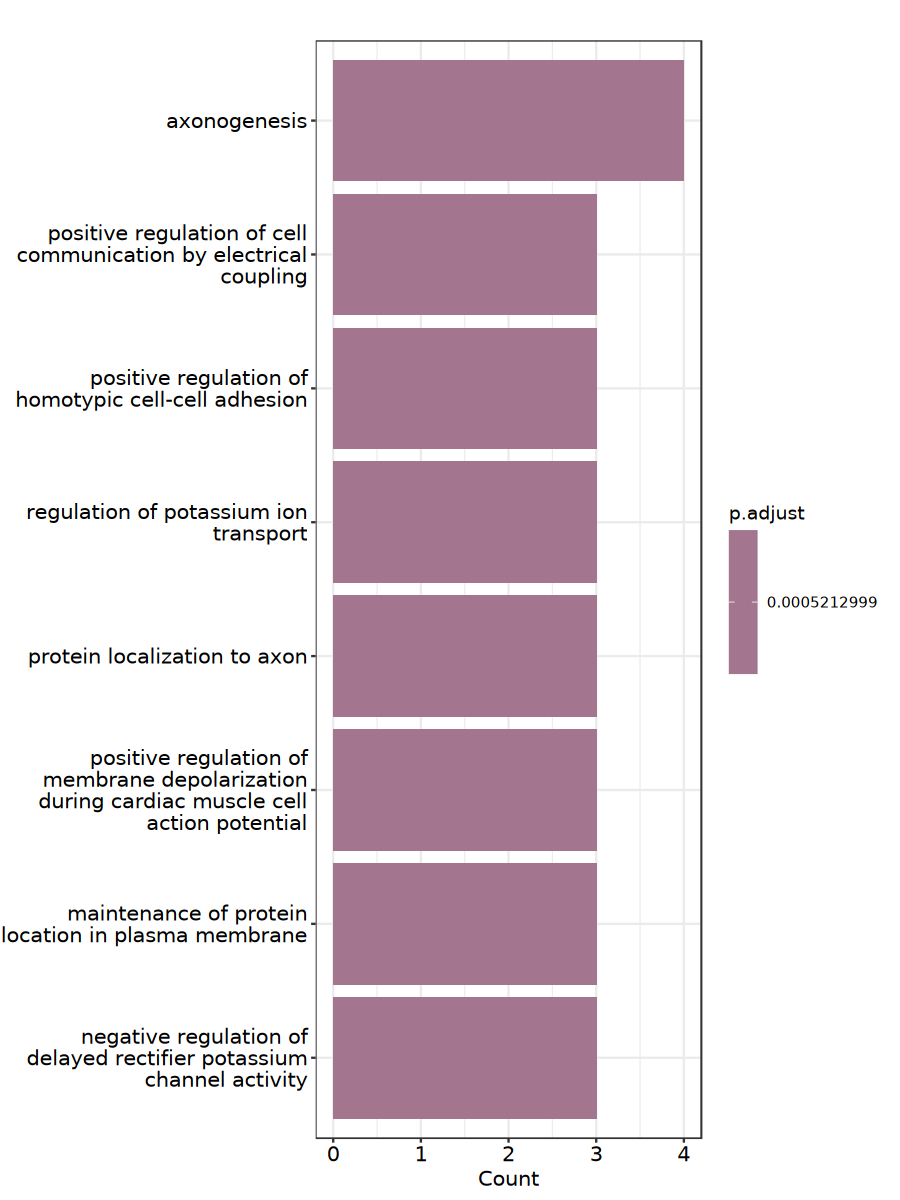

In [13]:
options(repr.plot.width=7.5, repr.plot.height=10)

barplot(res_sig.cc.cw)

looks like some terms involved in signalling (cell-cell adhesion, communication) but also some terms related to neurons

In [14]:
# CC vs. CH
res_sig.cc.ch <- enricher(
    gene = all_df$ch_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.ch))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched/over-represented GO terms

In [15]:
# CC vs. CB
res_sig.cc.cb <- enricher(
    gene = all_df$cb_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051537,GO:0051537,"2 iron, 2 sulfur cluster binding",3/50,33/16056,0.0001451612,0.0401534,0.02900916,LOC111123314/LOC111127059/LOC111126872,3
GO:0055078,GO:0055078,sodium ion homeostasis,2/50,10/16056,0.0004209239,0.0401534,0.02900916,LOC111118161/LOC111118627,2
GO:0044325,GO:0044325,transmembrane transporter binding,5/50,222/16056,0.0006168788,0.0401534,0.02900916,LOC111133968/LOC111100764/LOC111108482/LOC111110117/LOC111113824,5
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,4/50,127/16056,0.0006488694,0.0401534,0.02900916,LOC111133968/LOC111100764/LOC111108482/LOC111113824,4
GO:0097228,GO:0097228,sperm principal piece,2/50,13/16056,0.0007252552,0.0401534,0.02900916,LOC111118161/LOC111118627,2
GO:0015385,GO:0015385,sodium:proton antiporter activity,2/50,14/16056,0.0008444483,0.0401534,0.02900916,LOC111118161/LOC111118627,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


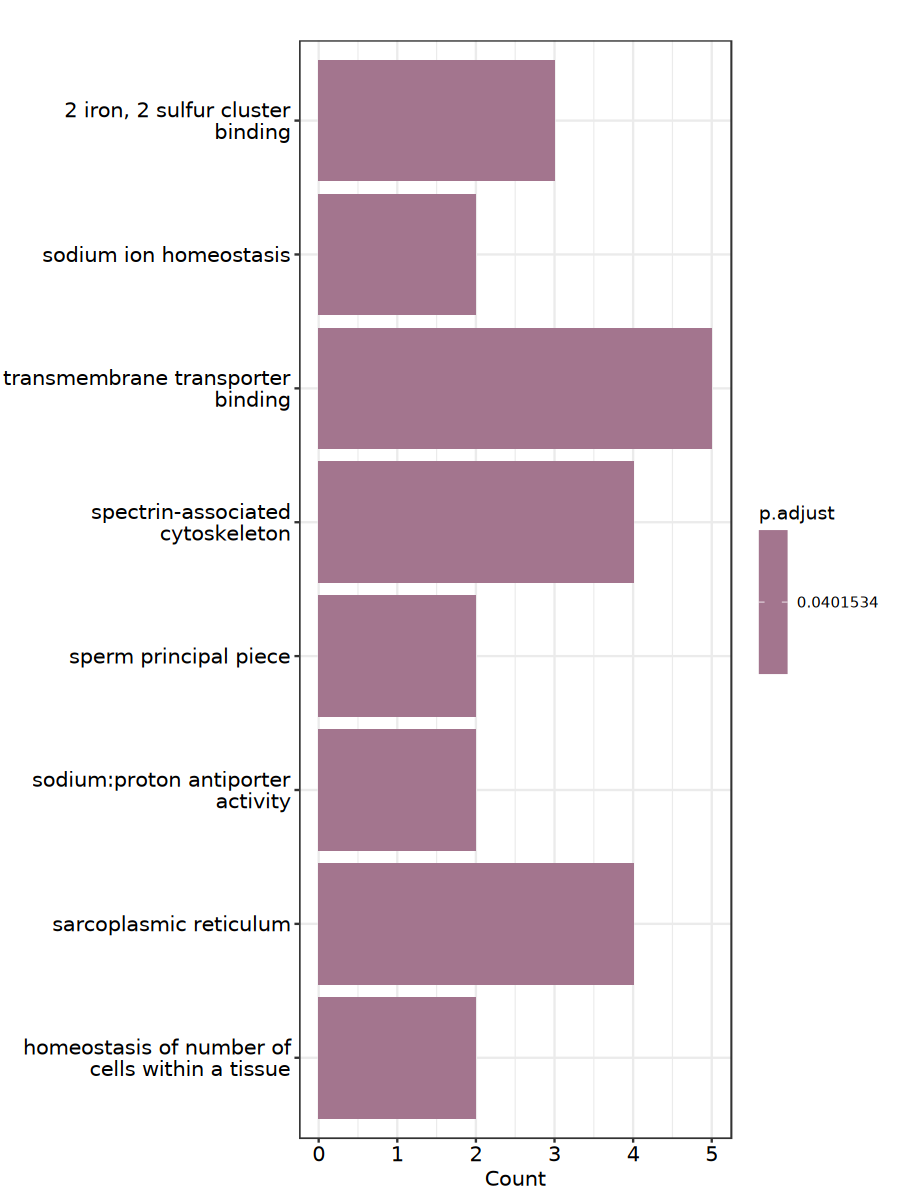

In [16]:
barplot(res_sig.cc.cb)

see terms related to structural processes  (cyotskeleton) 

### 3. Effect of timing of initial stress exposure
- WC vs. CW
- HC vs. CH
- BC vs. CB (no enriched terms)

In [17]:
# WC vs. CW
res_sig.wc.cw <- enricher(
    gene = all_df$cw_wc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008093,GO:0008093,cytoskeletal anchor activity,6/36,113/16056,1.743392e-07,3.434482e-05,1.908555e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,6/36,127/16056,3.487644e-07,3.435329e-05,1.909026e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0016529,GO:0016529,sarcoplasmic reticulum,6/36,146/16056,7.932727e-07,5.141202e-05,2.856986e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0030507,GO:0030507,spectrin binding,6/36,153/16056,1.043899e-06,5.141202e-05,2.856986e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0005200,GO:0005200,structural constituent of cytoskeleton,6/36,159/16056,1.307216e-06,5.150432e-05,2.862115e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0070469,GO:0070469,respirasome,3/36,12/16056,2.246010e-06,7.374398e-05,4.097983e-05,LOC111119097/LOC111119236/LOC111125731,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


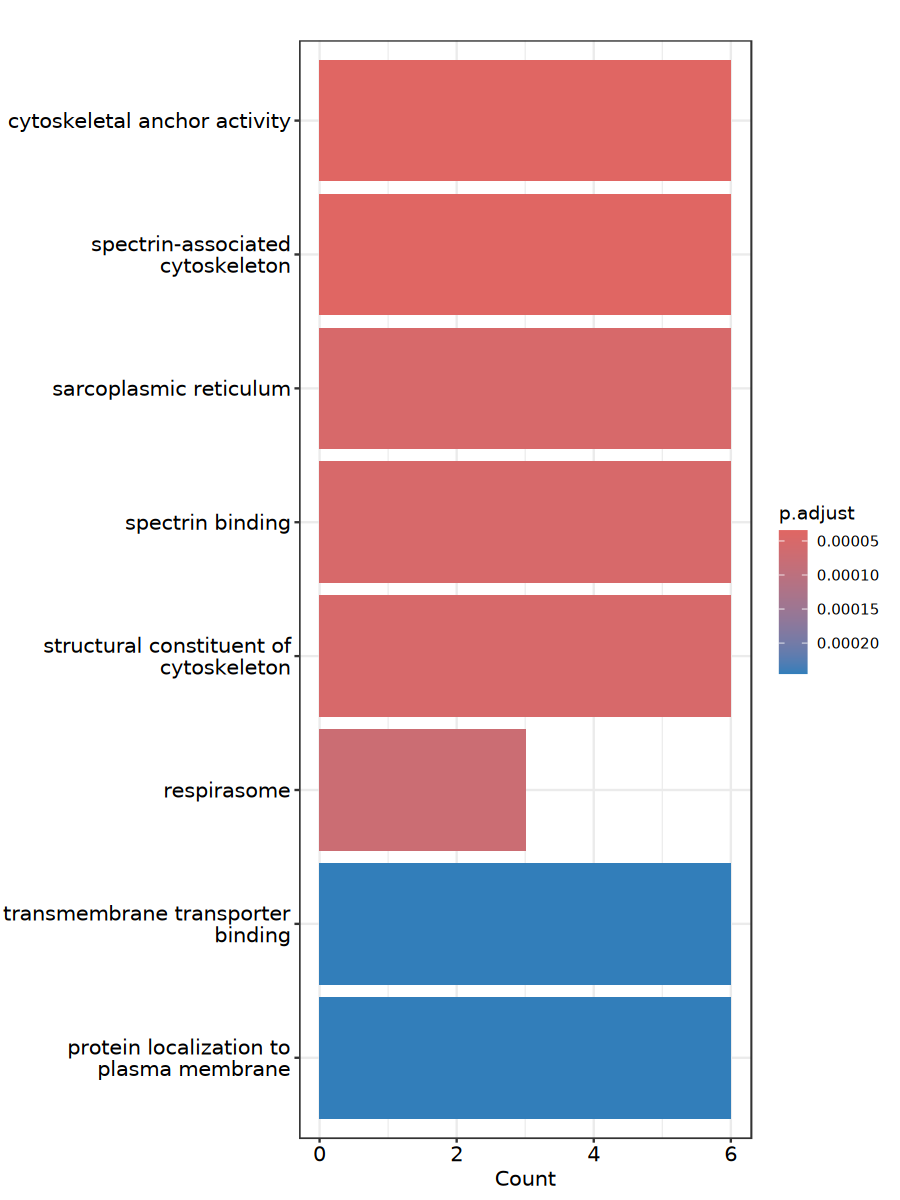

In [18]:
barplot(res_sig.wc.cw)

In [19]:
# HC vs. CH
res_sig.hc.ch <- enricher(
    gene = all_df$ch_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hc.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0009725,GO:0009725,response to hormone,3/41,46/16056,0.0002173772,0.03553074,0.02261443,LOC111104716/LOC111110558/LOC111110387,3
GO:0098632,GO:0098632,cell-cell adhesion mediator activity,2/41,10/16056,0.0002826053,0.03553074,0.02261443,LOC111125416/LOC111125415,2
GO:1904706,GO:1904706,negative regulation of vascular associated smooth muscle cell proliferation,2/41,12/16056,0.0004131482,0.03553074,0.02261443,LOC111110558/LOC111110387,2
GO:0071310,GO:0071310,cellular response to organic substance,2/41,15/16056,0.0006540983,0.04078557,0.02595899,LOC111110558/LOC111110387,2
GO:0045861,GO:0045861,negative regulation of proteolysis,2/41,17/16056,0.0008444769,0.04078557,0.02595899,LOC111110558/LOC111110387,2
GO:0050770,GO:0050770,regulation of axonogenesis,2/41,18/16056,0.0009485016,0.04078557,0.02595899,LOC111125416/LOC111125415,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


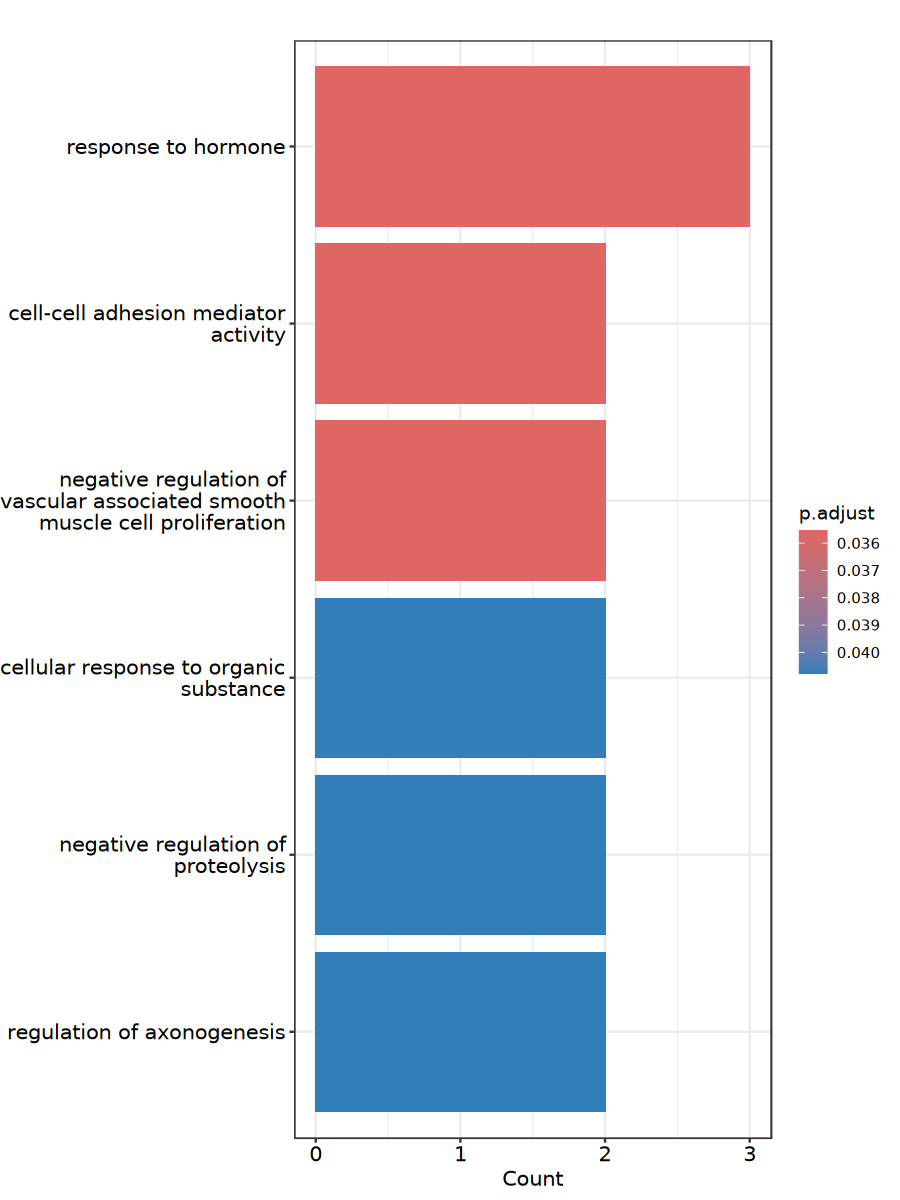

In [20]:
barplot(res_sig.hc.ch)

lots of signaling terms, some development (in terms of muscle cell proliferation), and some structural processes (cytoskeleton)

In [21]:
# BC vs. CB
res_sig.bc.cb <- enricher(
    gene = all_df$cb_bc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.cb))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

In [23]:
# CC vs. WW
res_sig.cc.ww <- enricher(
    gene = all_df$ww_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.ww))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0062023,GO:0062023,collagen-containing extracellular matrix,5/21,331/16056,5.602378e-05,0.01204511,0.005720323,LOC111105495/LOC111136853/LOC111134917/LOC111104743/LOC111109583,5
GO:0044325,GO:0044325,transmembrane transporter binding,4/21,222/16056,1.769715e-04,0.01534675,0.007288298,LOC111100764/LOC111108482/LOC111110117/LOC111113858,4
GO:0007409,GO:0007409,axonogenesis,3/21,125/16056,5.529683e-04,0.01534675,0.007288298,LOC111100764/LOC111108482/LOC111109183,3
GO:0030674,GO:0030674,protein-macromolecule adaptor activity,3/21,125/16056,5.529683e-04,0.01534675,0.007288298,LOC111100764/LOC111108482/LOC111110717,3
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,3/21,127/16056,5.791854e-04,0.01534675,0.007288298,LOC111100764/LOC111108482/LOC111113858,3
GO:0046847,GO:0046847,filopodium assembly,2/21,28/16056,6.033740e-04,0.01534675,0.007288298,LOC111109183/LOC111110717,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


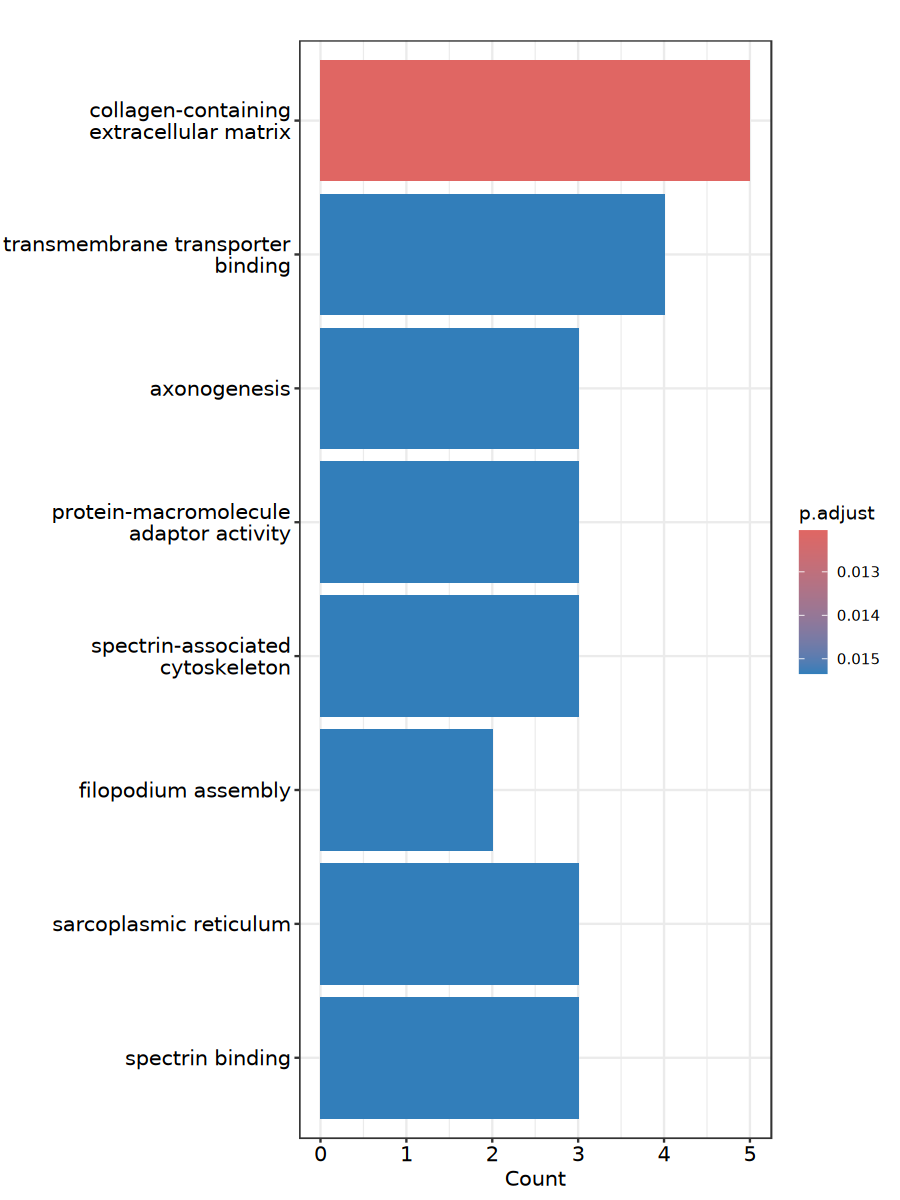

In [24]:
barplot(res_sig.cc.ww)

In [25]:
# CC vs. HH
res_sig.cc.hh <- enricher(
    gene = all_df$hh_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.hh))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,5/56,127/16056,7.911712e-05,0.01509125,0.00990453,LOC111100764/LOC111108482/LOC111106424/LOC111113858/LOC111110817,5
GO:0062023,GO:0062023,collagen-containing extracellular matrix,7/56,331/16056,1.447060e-04,0.01509125,0.00990453,LOC111105495/LOC111119491/LOC111125681/LOC111103201/LOC111109583/LOC111106152/LOC111117278,7
GO:0016529,GO:0016529,sarcoplasmic reticulum,5/56,146/16056,1.526739e-04,0.01509125,0.00990453,LOC111100764/LOC111108482/LOC111106424/LOC111113858/LOC111110817,5
GO:0030507,GO:0030507,spectrin binding,5/56,153/16056,1.900279e-04,0.01509125,0.00990453,LOC111100764/LOC111108482/LOC111106424/LOC111113858/LOC111110817,5
GO:0005200,GO:0005200,structural constituent of cytoskeleton,5/56,159/16056,2.272779e-04,0.01509125,0.00990453,LOC111100764/LOC111108482/LOC111106424/LOC111113858/LOC111110817,5
GO:0060856,GO:0060856,establishment of blood-brain barrier,2/56,10/16056,5.281074e-04,0.01838870,0.01206868,LOC111126581/LOC111126486,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


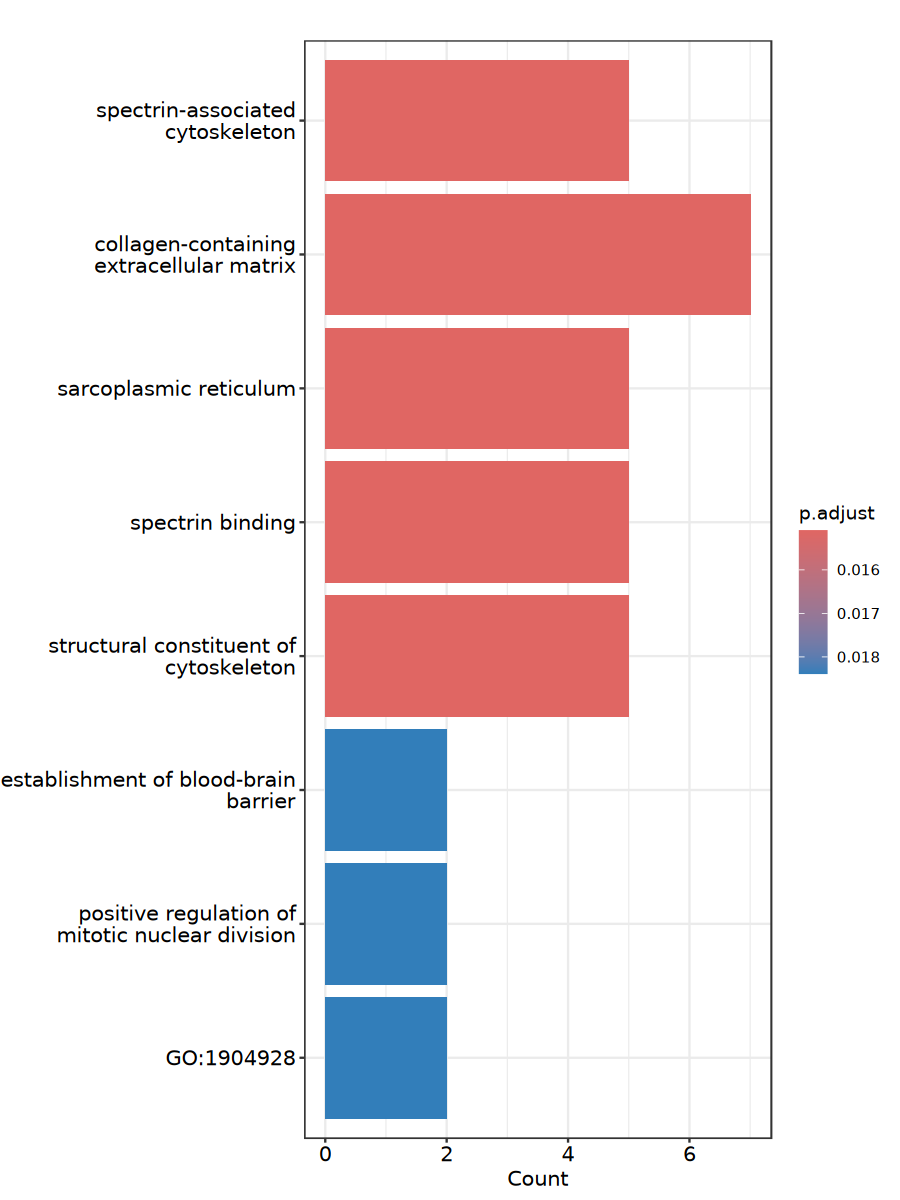

In [26]:
barplot(res_sig.cc.hh)

In [27]:
# CC vs. BB
res_sig.cc.bb <- enricher(
    gene = all_df$bb_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.bb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030507,GO:0030507,spectrin binding,5/43,153/16056,5.289675e-05,0.01967759,0.01414292,LOC111124681/LOC111100764/LOC111108482/LOC111106424/LOC111113858,5
GO:0044325,GO:0044325,transmembrane transporter binding,5/43,222/16056,3.031073e-04,0.04499460,0.03233907,LOC111100764/LOC111108482/LOC111106424/LOC111110117/LOC111113858,5
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,4/43,127/16056,3.628597e-04,0.04499460,0.03233907,LOC111100764/LOC111108482/LOC111106424/LOC111113858,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


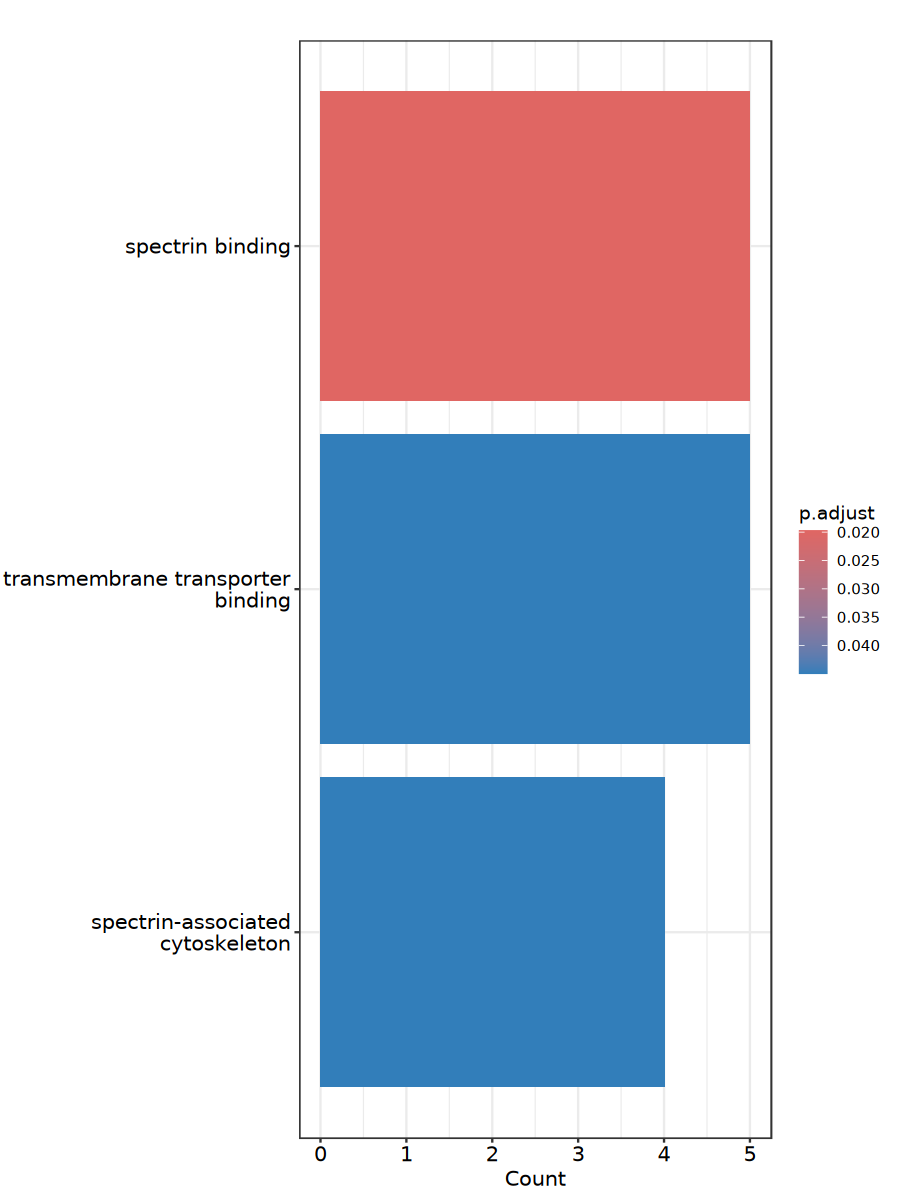

In [64]:
barplot(res_sig.cc.bb)

### 5. Effect of initial exposure on response in later exposure

#### 5A. matched priming
- WW vs. CW
- HH vs. CH
- BB vs. CB

In [28]:
# WW vs. CW
res_sig.ww.cw <- enricher(
    gene = all_df$ww_cw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.ww.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015132,GO:0015132,prostaglandin transmembrane transporter activity,2/27,15/16056,0.0002821093,0.01793527,0.01261826,LOC111131313/LOC111127793,2
GO:0015347,GO:0015347,sodium-independent organic anion transmembrane transporter activity,2/27,15/16056,0.0002821093,0.01793527,0.01261826,LOC111131313/LOC111127793,2
GO:0043252,GO:0043252,sodium-independent organic anion transport,2/27,16/16056,0.0003220762,0.01793527,0.01261826,LOC111131313/LOC111127793,2
GO:0015349,GO:0015349,thyroid hormone transmembrane transporter activity,2/27,18/16056,0.0004097960,0.01793527,0.01261826,LOC111131313/LOC111127793,2
GO:0008514,GO:0008514,organic anion transmembrane transporter activity,2/27,19/16056,0.0004575325,0.01793527,0.01261826,LOC111131313/LOC111127793,2
GO:0043005,GO:0043005,neuron projection,5/27,422/16056,0.0006131388,0.02002920,0.01409144,LOC111107865/LOC111113858/LOC111110817/LOC111110717/LOC111116878,5


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


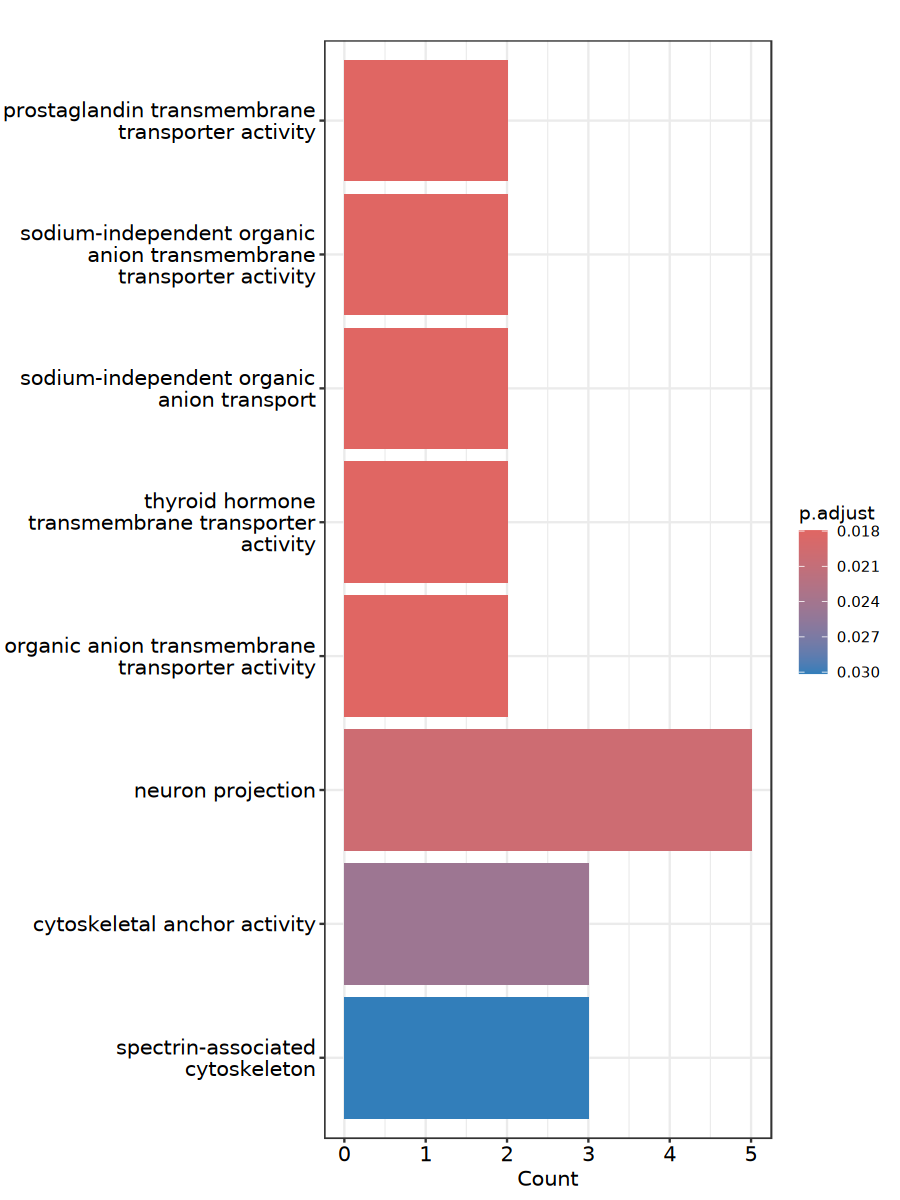

In [29]:
barplot(res_sig.ww.cw)

a lot of the terms are involved in transport - so cell signaling/communication?

In [30]:
# HH vs. CH
res_sig.hh.ch <- enricher(
    gene = all_df$hh_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hh.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0002053,GO:0002053,positive regulation of mesenchymal cell proliferation,3/79,14/16056,4.013340e-05,0.01200425,0.01017731,LOC111126581/LOC111126486/LOC111124435,3
GO:0015026,GO:0015026,coreceptor activity,3/79,16/16056,6.130696e-05,0.01200425,0.01017731,LOC111126581/LOC111126486/LOC111129173,3
GO:0061178,GO:0061178,regulation of insulin secretion involved in cellular response to glucose stimulus,3/79,18/16056,8.870134e-05,0.01200425,0.01017731,LOC111118161/LOC111126581/LOC111126486,3
GO:0045199,GO:0045199,maintenance of epithelial cell apical/basal polarity,4/79,85/16056,8.125613e-04,0.04250289,0.03603434,LOC111103219/LOC111106424/LOC111113824/LOC111110817,4
GO:0008745,GO:0008745,N-acetylmuramoyl-L-alanine amidase activity,2/79,10/16056,1.048511e-03,0.04250289,0.03603434,LOC111099527/LOC111101087,2
GO:0009253,GO:0009253,peptidoglycan catabolic process,2/79,10/16056,1.048511e-03,0.04250289,0.03603434,LOC111099527/LOC111101087,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


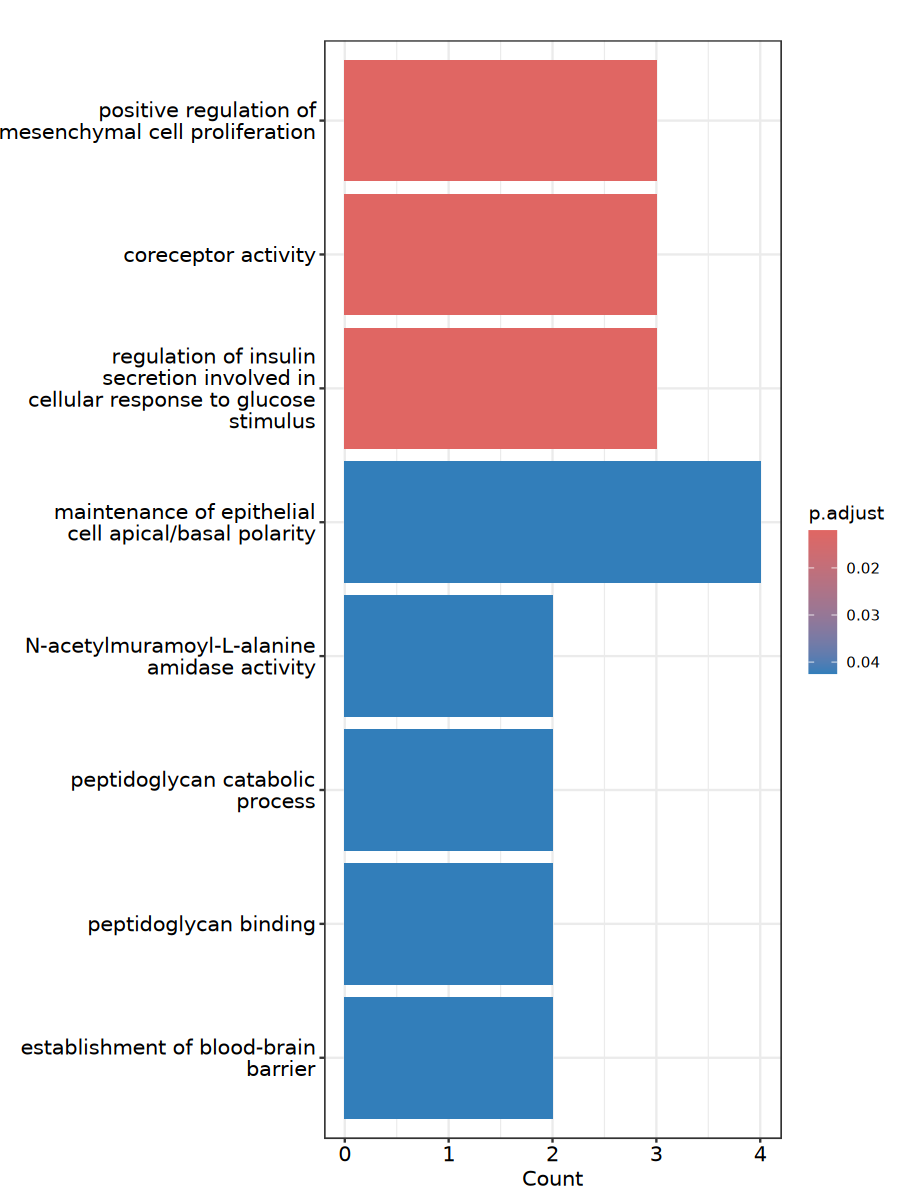

In [31]:
barplot(res_sig.hh.ch)

some terms involved in signaling, immune response, development

In [32]:
# BB vs. CB
res_sig.bb.cb <- enricher(
    gene = all_df$cb_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bb.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006887,GO:0006887,exocytosis,5/43,158/16056,6.164368e-05,0.008445204,0.005845275,LOC111134744/LOC111105268/LOC111106424/LOC111113824/LOC111113858,5
GO:0045199,GO:0045199,maintenance of epithelial cell apical/basal polarity,4/43,85/16056,7.712516e-05,0.008445204,0.005845275,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0031430,GO:0031430,M band,4/43,105/16056,1.751520e-04,0.011248779,0.007785745,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0008093,GO:0008093,cytoskeletal anchor activity,4/43,113/16056,2.322898e-04,0.011248779,0.007785745,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0005198,GO:0005198,structural molecule activity,4/43,116/16056,2.568214e-04,0.011248779,0.007785745,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,4/43,127/16056,3.628597e-04,0.013244378,0.009166981,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


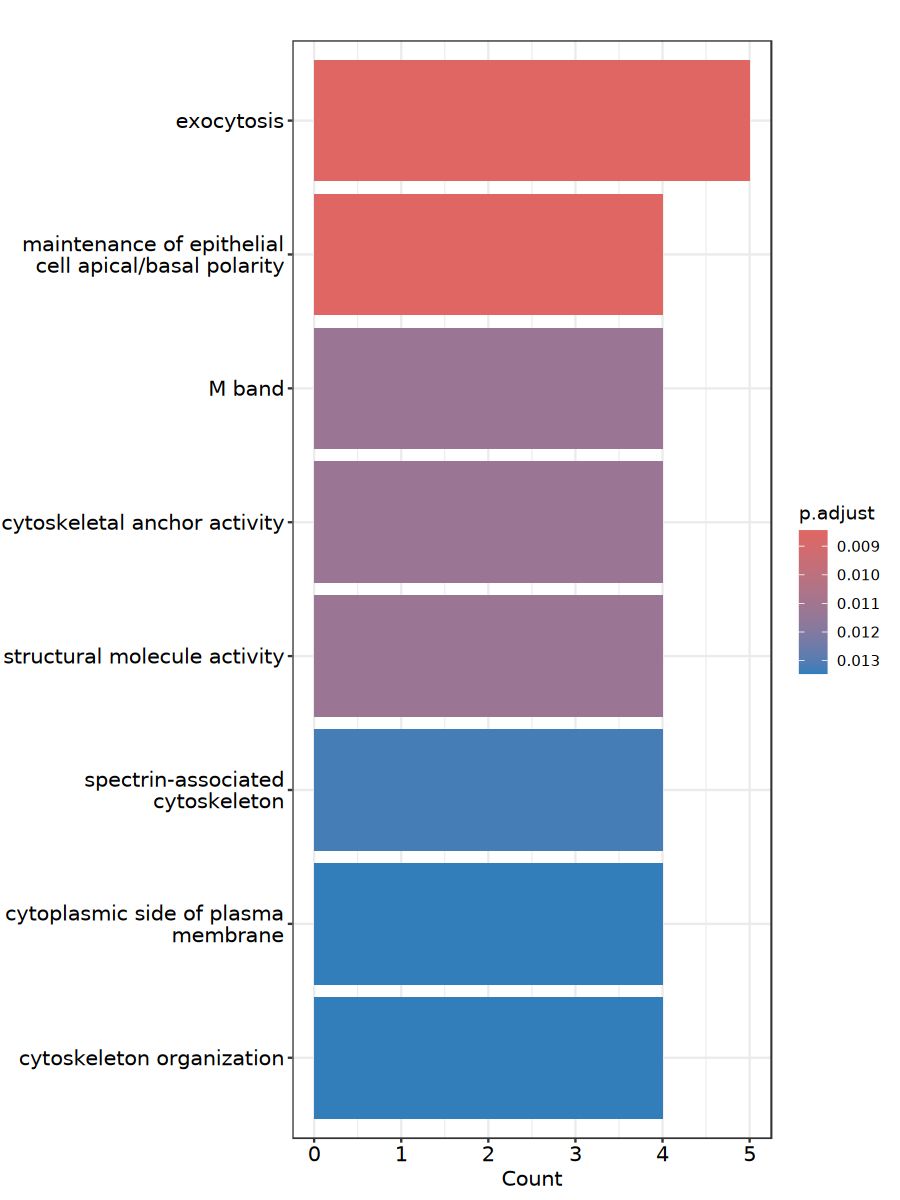

In [33]:
barplot(res_sig.bb.cb)

terns involved in structural processes

#### 5B. semi-matched priming: in context of later single stress
- CH vs. BH
- CW vs. BW (no enriched terms)

In [34]:
# CH vs. BH
res_sig.ch.bh <- enricher(
    gene = all_df$bh_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.ch.bh))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0098635,GO:0098635,protein complex involved in cell-cell adhesion,3/105,11/16056,4.316504e-05,0.02425875,0.02353630,LOC111113589/LOC111125612/LOC111120163,3
GO:0007342,GO:0007342,fusion of sperm to egg plasma membrane involved in single fertilization,3/105,16/16056,1.430512e-04,0.04019740,0.03900028,LOC111113589/LOC111125612/LOC111120163,3


In [35]:
# CW vs. BW
res_sig.cw_bw <- enricher(
    gene = all_df$bw_cw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cw_bw))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched GO terms

#### 5C. semi matched priming: in context of later multiple stress
- CB vs. WB
- CB vs. HB

In [36]:
# CB vs. WB
res_sig.wb.cb <- enricher(
    gene = all_df$wb_cb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wb.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015969,GO:0015969,guanosine tetraphosphate metabolic process,6/91,27/16056,7.543712e-09,3.907643e-06,3.525693e-06,LOC111109405/LOC111108435/LOC111107391/LOC111108877/LOC111108387/LOC111110716,6
GO:0005044,GO:0005044,scavenger receptor activity,10/91,255/16056,1.779362e-06,4.608547e-04,4.158087e-04,LOC111109066/LOC111120583/LOC111134744/LOC111100053/LOC111105265/LOC111112545/LOC111114724/LOC111113113/LOC111115548/LOC111115000,10
GO:0042589,GO:0042589,zymogen granule membrane,4/91,33/16056,3.484003e-05,6.015712e-03,5.427710e-03,LOC111120904/LOC111100053/LOC111105265/LOC111115551,4
GO:0009566,GO:0009566,fertilization,4/91,36/16056,4.950581e-05,6.411003e-03,5.784363e-03,LOC111119920/LOC111110547/LOC111108308/LOC111116779,4
GO:0007342,GO:0007342,fusion of sperm to egg plasma membrane involved in single fertilization,3/91,16/16056,9.349808e-05,9.686401e-03,8.739610e-03,LOC111121853/LOC111115657/LOC111114598,3
GO:0004252,GO:0004252,serine-type endopeptidase activity,5/91,107/16056,3.530996e-04,3.048426e-02,2.750460e-02,LOC111120583/LOC111119920/LOC111134744/LOC111105265/LOC111113113,5


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


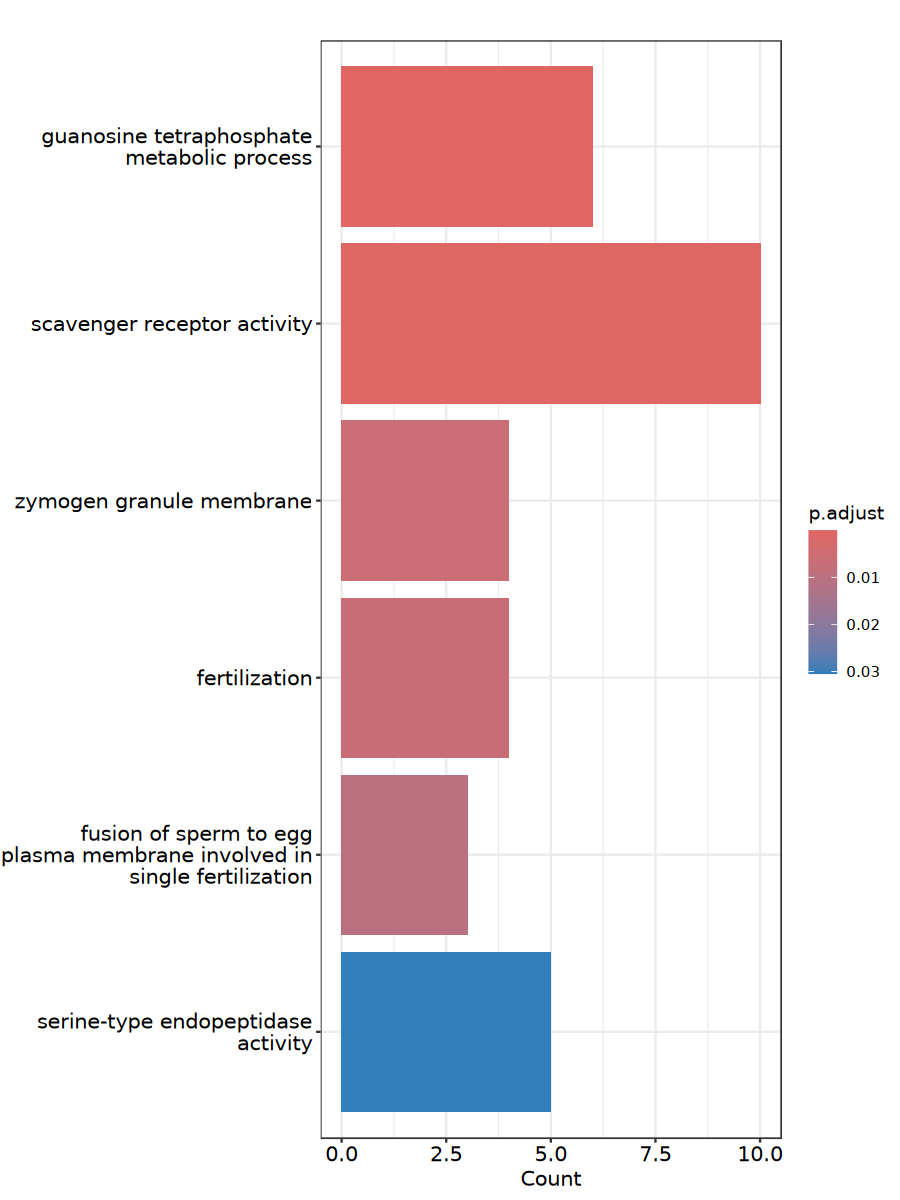

In [37]:
barplot(res_sig.wb.cb)

In [38]:
# CB vs. HB
res_sig.cb.hb <- enricher(
    gene = all_df$hb_cb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cb.hb))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

### 6. Effect of initial exposure on subsequent response to stress
- WW vs. WC (no enriched terms)
- HH vs. HC
- BB vs. BC

In [39]:
# WW vs. WC
res_sig.wc.ww <- enricher(
    gene = all_df$wc_ww,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.ww))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched GO terms

In [41]:
# HH vs. HC
res_sig.hh.hc <- enricher(
    gene = all_df$hc_hh,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hh.hc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0062023,GO:0062023,collagen-containing extracellular matrix,11/79,331/16056,6.269926e-07,0.000255813,0.0002474971,LOC111105495/LOC111119491/LOC111125681/LOC111104743/LOC111104257/LOC111109583/LOC111108101/LOC111106152/LOC111111748/LOC111116035/LOC111117278,11


In [43]:
# BB vs. BC
res_sig.bb_bc <- enricher(
    gene = all_df$bc_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bb_bc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004197,GO:0004197,cysteine-type endopeptidase activity,5/80,74/16056,3.331138e-05,0.01772166,0.0159544,LOC111103124/LOC111113026/LOC111113028/LOC111113025/LOC111113029,5


### 7. Effect of initial single/multiple stress on response in ...

#### 7A. ...later single stress
- BH vs. HH
- BW vs. WW

In [45]:
# BH vs. HH
res_sig.bh_hh <- enricher(
    gene = all_df$bh_hh,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bh_hh))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030199,GO:0030199,collagen fibril organization,4/72,42/16056,3.657364e-05,0.01572667,0.01459096,LOC111105495/LOC111123816/LOC111125681/LOC111109250,4
GO:0062023,GO:0062023,collagen-containing extracellular matrix,8/72,331/16056,1.139041e-04,0.02448938,0.02272087,LOC111105495/LOC111119491/LOC111123816/LOC111125681/LOC111109583/LOC111106152/LOC111109250/LOC111117278,8


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


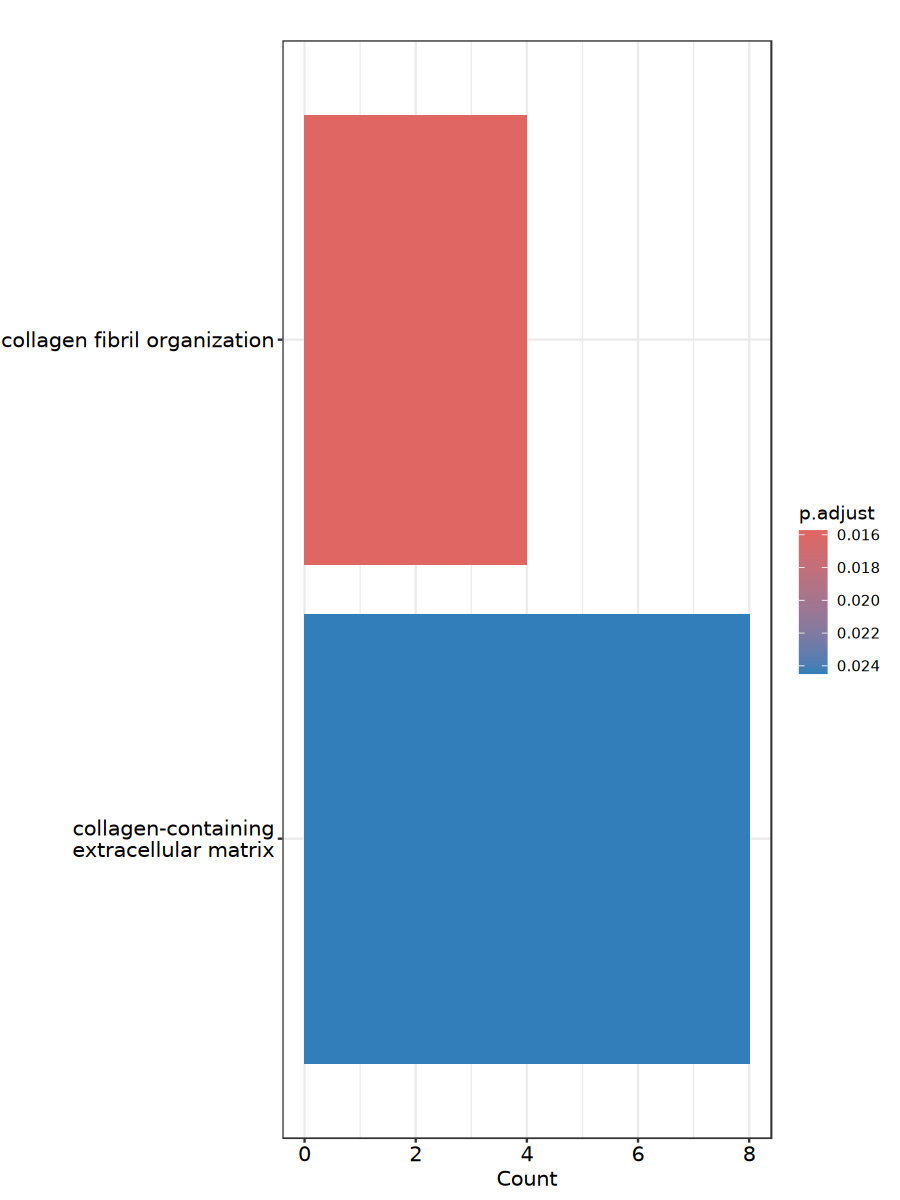

In [46]:
barplot(res_sig.bh_hh)

In [47]:
# BW vs. WW
res_sig.bw.ww <- enricher(
    gene = all_df$bw_ww,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bw.ww))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


oxidoreductase activity seems to come up a lot

#### 7B. ...later multiple stressors
- HB vs. BB
- WB vs. BB

In [48]:
# HB vs. BB
res_sig.hb.bb <- enricher(
    gene = all_df$hb_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hb.bb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008584,GO:0008584,male gonad development,3/30,43/16056,6.906917e-05,0.01519522,0.01141459,LOC111122111/LOC111110547/LOC111108308,3
GO:0007286,GO:0007286,spermatid development,3/30,61/16056,1.969089e-04,0.02165998,0.01627089,LOC111120728/LOC111110547/LOC111108308,3
GO:0048873,GO:0048873,homeostasis of number of cells within a tissue,2/30,17/16056,4.510625e-04,0.03307792,0.02484801,LOC111110547/LOC111108308,2


... interesting?

In [49]:
# WB vs. BB
res_sig.wb.bb <- enricher(
    gene = all_df$wb_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wb.bb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015969,GO:0015969,guanosine tetraphosphate metabolic process,8/31,27/16056,1.563259e-16,3.720556e-14,2.51767e-14,LOC111109405/LOC111108435/LOC111107388/LOC111107391/LOC111107389/LOC111108877/LOC111108529/LOC111108387,8


### 8. Shared/unique responses among stressors with ...

#### 8A. different early stressors
- WC vs. HC
- BC vs. HC
- BC vs. WC

In [50]:
# WC vs. HC
res_sig.wc.hc <- enricher(
    gene = all_df$wc_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.hc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031232,GO:0031232,extrinsic component of external side of plasma membrane,3/37,32/16056,5.336012e-05,0.01168587,0.008312944,LOC111123495/LOC111104743/LOC111108101,3


In [51]:
# BC vs. HC
res_sig.bc.hc <- enricher(
    gene = all_df$bc_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.hc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0062023,GO:0062023,collagen-containing extracellular matrix,12/65,331/16056,7.308097e-09,3.507887e-06,2.969395e-06,LOC111105495/LOC111123516/LOC111104743/LOC111104257/LOC111108101/LOC111110143/LOC111106107/LOC111106152/LOC111111748/LOC111116035/LOC111115918/LOC111113029,12


In [53]:
# BC vs. WC
res_sig.bc.wc <- enricher(
    gene = all_df$bc_wc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.wc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004197,GO:0004197,cysteine-type endopeptidase activity,5/71,74/16056,1.863121e-05,0.007427236,0.005932591,LOC111103124/LOC111113026/LOC111113028/LOC111113025/LOC111113029,5
GO:0002053,GO:0002053,positive regulation of mesenchymal cell proliferation,3/71,14/16056,2.912641e-05,0.007427236,0.005932591,LOC111126581/LOC111126486/LOC111124435,3
GO:0062023,GO:0062023,collagen-containing extracellular matrix,8/71,331/16056,1.030693e-04,0.017521787,0.013995731,LOC111105495/LOC111123516/LOC111134355/LOC111110143/LOC111106107/LOC111106152/LOC111110110/LOC111113029,8
GO:0030574,GO:0030574,collagen catabolic process,3/71,26/16056,2.002722e-04,0.022908505,0.018298434,LOC111113028/LOC111113025/LOC111113029,3
GO:0019897,GO:0019897,extrinsic component of plasma membrane,3/71,27/16056,2.245932e-04,0.022908505,0.018298434,LOC111103124/LOC111113113/LOC111111873,3
GO:0050839,GO:0050839,cell adhesion molecule binding,4/71,74/16056,3.198146e-04,0.027184243,0.021713730,LOC111125416/LOC111125415/LOC111123516/LOC111110110,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


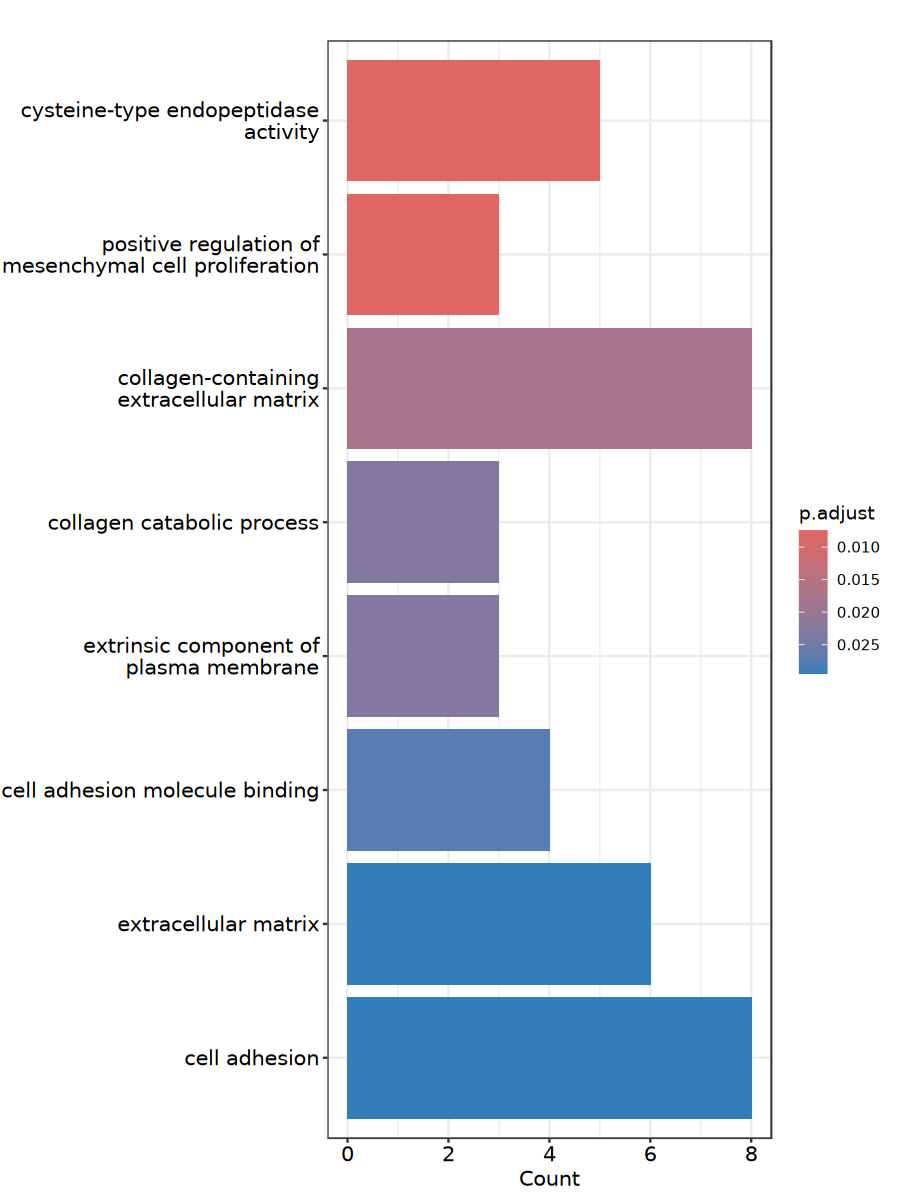

In [65]:
barplot(res_sig.bc.wc)

#### 8B. different late stressors
- CW vs. CH
- CB vs. CH (no enriched terms)
- CW vs. CB (no enriched terms)

In [54]:
# CW vs. CH
res_sig.cw.ch <- enricher(
    gene = all_df$cw_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cw.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008093,GO:0008093,cytoskeletal anchor activity,5/50,113/16056,2.600059e-05,0.007474880,0.006237063,LOC111101858/LOC111107865/LOC111113824/LOC111113858/LOC111110817,5
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,5/50,127/16056,4.557853e-05,0.007474880,0.006237063,LOC111101858/LOC111107865/LOC111113824/LOC111113858/LOC111110817,5
GO:0016529,GO:0016529,sarcoplasmic reticulum,5/50,146/16056,8.847040e-05,0.007649404,0.006382686,LOC111101858/LOC111107865/LOC111113824/LOC111113858/LOC111110817,5
GO:0030507,GO:0030507,spectrin binding,5/50,153/16056,1.103535e-04,0.007649404,0.006382686,LOC111101858/LOC111107865/LOC111113824/LOC111113858/LOC111110817,5
GO:0005200,GO:0005200,structural constituent of cytoskeleton,5/50,159/16056,1.322292e-04,0.007649404,0.006382686,LOC111101858/LOC111107865/LOC111113824/LOC111113858/LOC111110817,5
GO:0045199,GO:0045199,maintenance of epithelial cell apical/basal polarity,4/50,85/16056,1.399281e-04,0.007649404,0.006382686,LOC111101858/LOC111113824/LOC111113858/LOC111110817,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


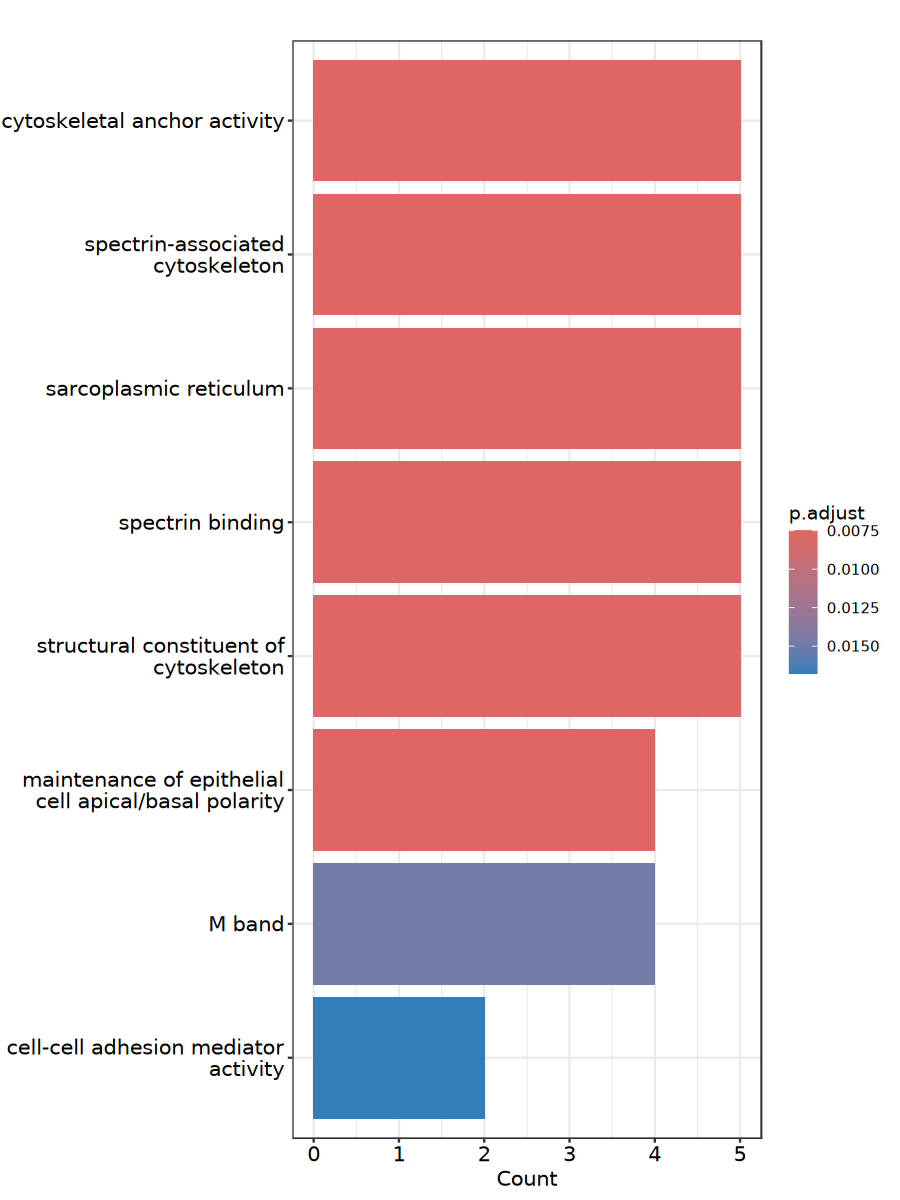

In [55]:
barplot(res_sig.cw.ch)

terms invovled in structural processes (cytoskeleton)

In [56]:
# CB vs. CH
res_sig.cb.ch <- enricher(
    gene = all_df$cb_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cb.ch))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

In [57]:
# CB vs. CW
res_sig.cb.cw <- enricher(
    gene = all_df$cb_cw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cb.cw))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

### 9. Effect of order of stresses on GE
- WH vs. HW (no enriched terms)
- WB vs. BW
- HB vs. BH

In [58]:
# WH vs. HW
res_sig.wh.hw <- enricher(
    gene = all_df$wh_hw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wh.hw))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched GO terms

In [60]:
# BW vs. WB
res_sig.bw.wb <- enricher(
    gene = all_df$wb_bw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bw.wb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015969,GO:0015969,guanosine tetraphosphate metabolic process,6/92,27/16056,8.060944e-09,4.231995e-06,3.750460e-06,LOC111109405/LOC111108435/LOC111107391/LOC111108877/LOC111108529/LOC111108387,6
GO:0031012,GO:0031012,extracellular matrix,10/92,221/16056,5.365276e-07,1.408385e-04,1.248133e-04,LOC111127456/LOC111127171/LOC111125919/LOC111126283/LOC111134056/LOC111134354/LOC111134355/LOC111109583/LOC111108454/LOC111117324,10
GO:0030198,GO:0030198,extracellular matrix organization,7/92,119/16056,5.354547e-06,9.370457e-04,8.304245e-04,LOC111125919/LOC111126283/LOC111134056/LOC111134354/LOC111134355/LOC111109583/LOC111108454,7
GO:0005518,GO:0005518,collagen binding,4/92,55/16056,2.753438e-04,3.613888e-02,3.202683e-02,LOC111125919/LOC111126283/LOC111134354/LOC111134355,4
GO:0062023,GO:0062023,collagen-containing extracellular matrix,8/92,331/16056,6.206801e-04,4.772427e-02,4.229399e-02,LOC111126283/LOC111134056/LOC111134058/LOC111134354/LOC111134355/LOC111109583/LOC111106152/LOC111108454,8
GO:0050839,GO:0050839,cell adhesion molecule binding,4/92,74/16056,8.551013e-04,4.772427e-02,4.229399e-02,LOC111125919/LOC111126283/LOC111109583/LOC111108454,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


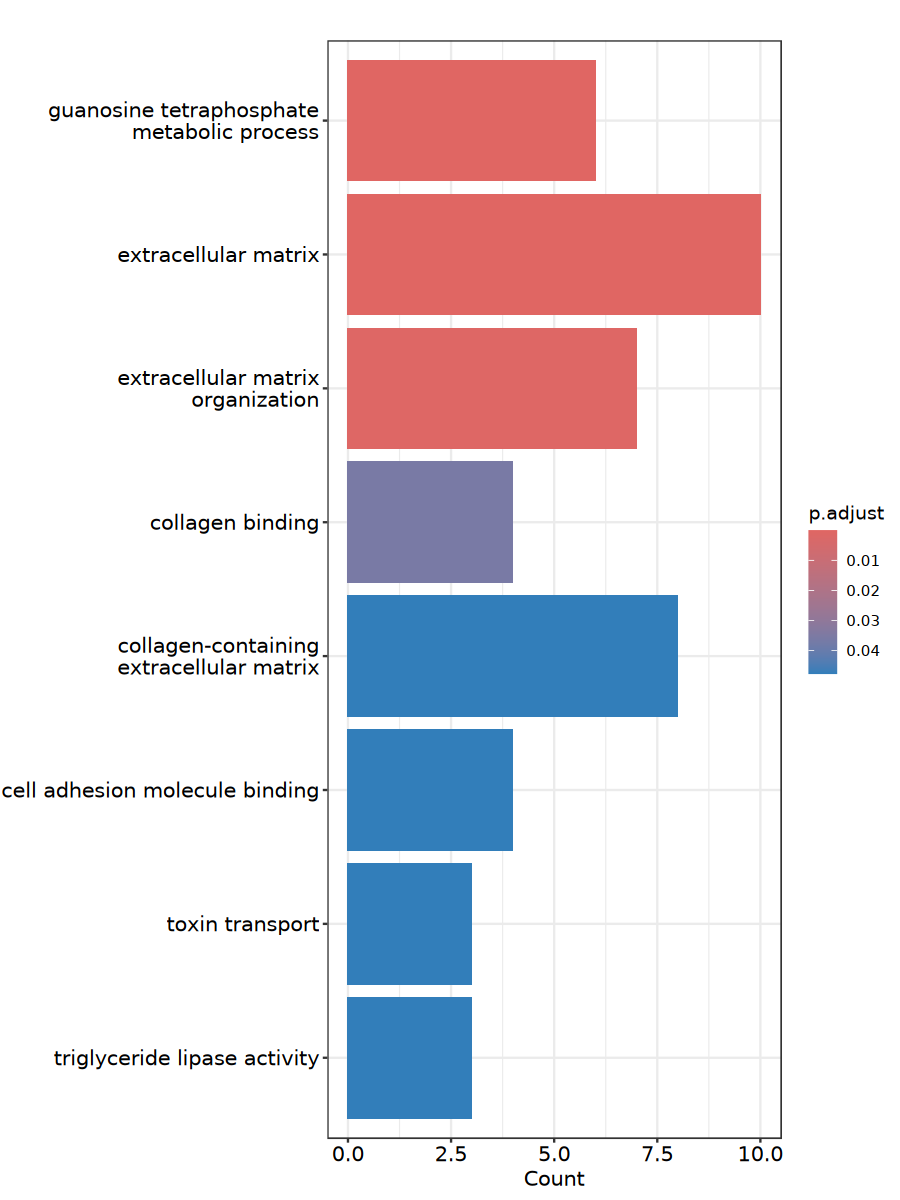

In [61]:
barplot(res_sig.bw.wb)

In [62]:
# BH vs. HB
res_sig.bh.hb <- enricher(
    gene = all_df$hb_bh,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bh.hb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004601,GO:0004601,peroxidase activity,5/102,41/16056,5.858319e-06,0.003063901,0.002904493,LOC111101430/LOC111099775/LOC111123816/LOC111104184/LOC111103001,5
GO:0004500,GO:0004500,dopamine beta-monooxygenase activity,3/102,15/16056,1.071460e-04,0.013730212,0.013015859,LOC111122967/LOC111127803/LOC111127802,3
GO:0006589,GO:0006589,octopamine biosynthetic process,3/102,16/16056,1.312640e-04,0.013730212,0.013015859,LOC111122967/LOC111127803/LOC111127802,3
GO:0042420,GO:0042420,dopamine catabolic process,3/102,16/16056,1.312640e-04,0.013730212,0.013015859,LOC111122967/LOC111127803/LOC111127802,3
GO:0140825,GO:0140825,lactoperoxidase activity,3/102,16/16056,1.312640e-04,0.013730212,0.013015859,LOC111123816/LOC111104184/LOC111103001,3
GO:0042421,GO:0042421,norepinephrine biosynthetic process,3/102,17/16056,1.586572e-04,0.013829623,0.013110099,LOC111122967/LOC111127803/LOC111127802,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


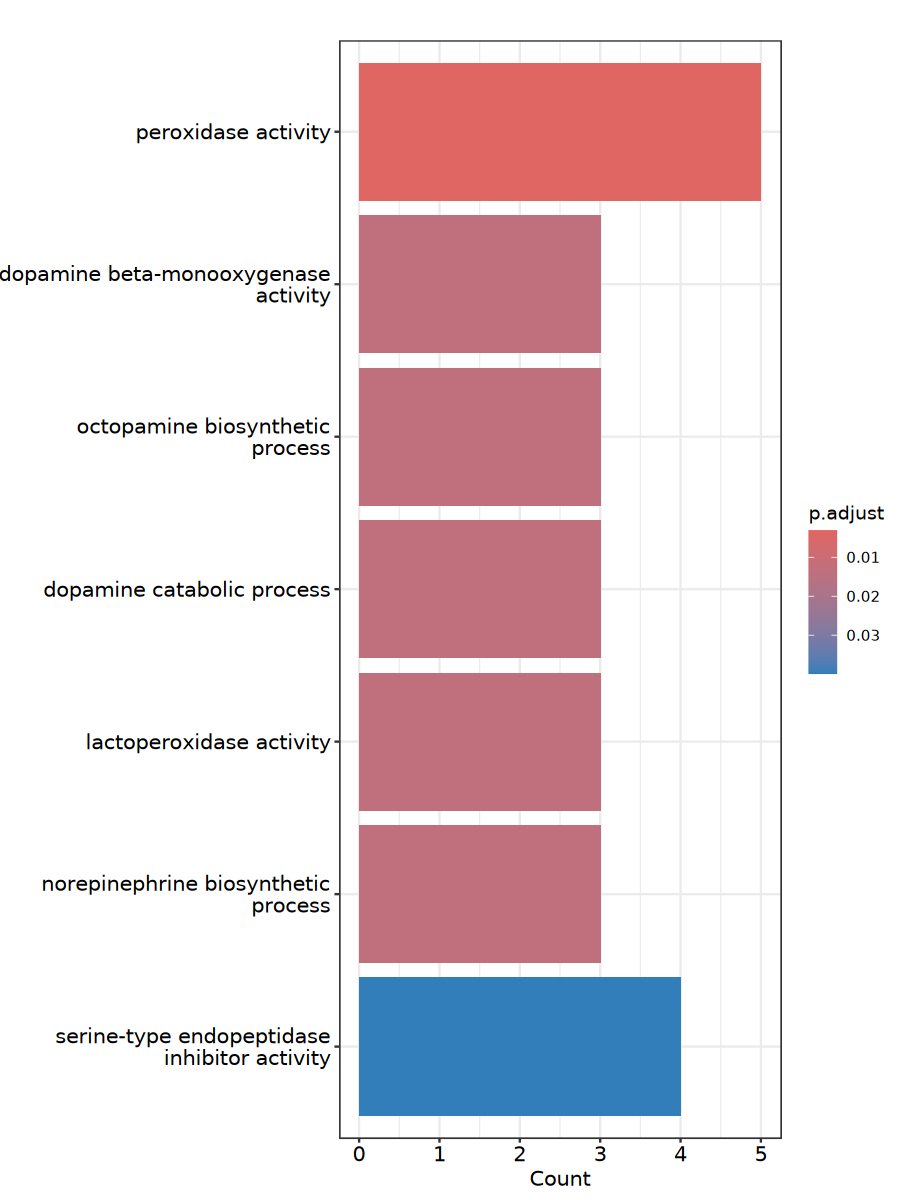

In [63]:
barplot(res_sig.bh.hb)